In [1]:
import numpy as np
import cv2 as cv
import glob

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,6,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('img/*.jpg')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,7), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,7), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
        
cv.destroyAllWindows()

In [2]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)

[[879.64824438   0.         475.08574496]
 [  0.         879.5161199  377.65027102]
 [  0.           0.           1.        ]]


In [3]:
img = cv.imread('img/2023-05-31-212912.jpg', cv.IMREAD_GRAYSCALE)
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [4]:
# undistort
def undistort(img):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [5]:
# remapping
def remap(img):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
from glob import glob

def results(path: str):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)

    plt.figure(figsize=(16,8))

    plt.subplot(231)
    plt.title('Imagem Original')
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, 'gray')
    
    und = undistort(img)
    plt.subplot(232)
    plt.title('Undistort')
    plt.xticks([]), plt.yticks([])
    plt.imshow(und, 'gray')

    remp = remap(img)
    plt.subplot(233)
    plt.title('Remapping')
    plt.xticks([]), plt.yticks([])
    plt.imshow(remp, 'gray')

    plt.subplot(212)
    plt.title('Overlay')
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, 'gray')
    plt.imshow(und, 'gray', alpha=0.5)
    plt.imshow(remp, 'gray', alpha=0.5)

imgs = glob(r'img/*.jpg')
imgs.sort()
interactive(results, path=imgs)

interactive(children=(Dropdown(description='path', options=('img/2023-05-31-212424.jpg', 'img/2023-05-31-21283…

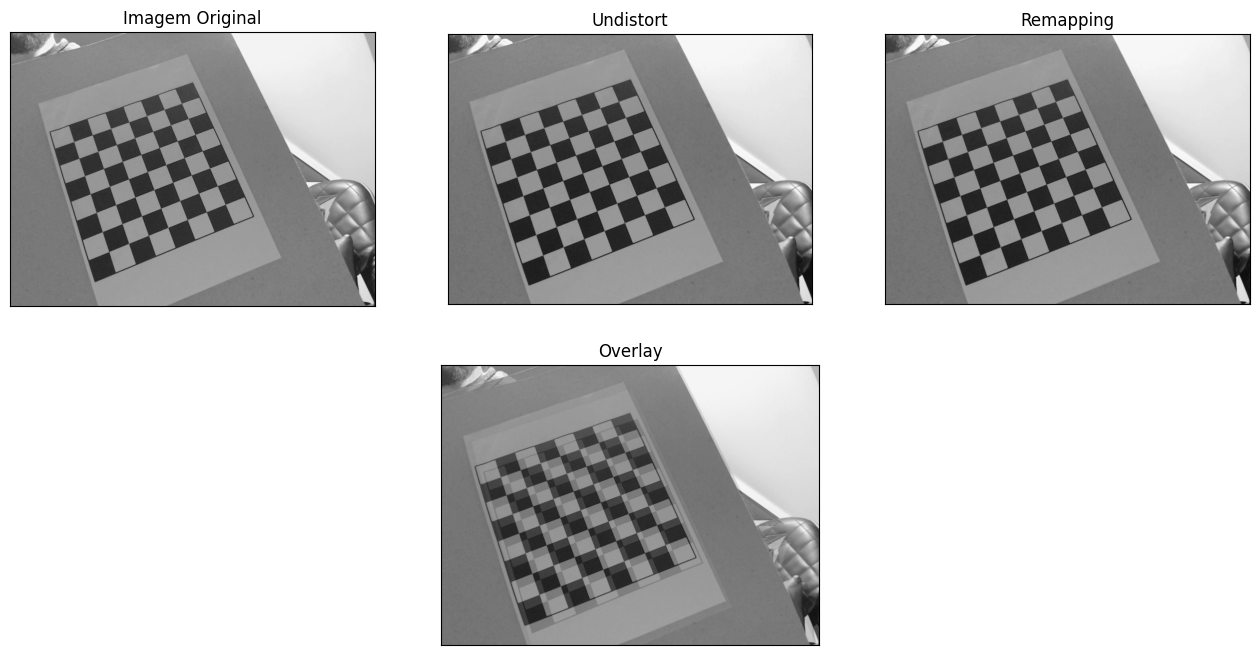

In [7]:
results('img/2023-05-31-213136.jpg')